In [128]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation

In [369]:
def random_flower_attraction(features=2, num_flowers = 10, max_attraction = 10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_flowers) * max_attraction

In [414]:
def random_flower_position(num_flowers = 10, max_position = 10):
    # Random initial condition, only positive, numbers between 0 and max_position
    return np.random.rand(2, num_flowers) * max_position

In [415]:
def random_bee_position(num_bees = 10, max_position = 10):
    # Random initial condition x and y, only positive coordinates
    return np.random.rand(2, num_bees) * max_position

In [417]:
def random_bee_attraction(features=2, num_bees = 10, max_attraction=10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_bees) * max_attraction

In [499]:
def gauss_dist(distances, sigma):
    # Gaussian distance function
    return np.exp(-np.linalg.norm(distances, axis=0)**2/(2*sigma**2))

In [522]:
def attraction_to_flower(mutual_attraction, mutual_distances, sigma=1):
    """
    Params:
        mutual_attraction: features x num_flowers 
        mutual_distances: 2 x num_flowers
        max_velocity: float
    """
    # find the unit vector of the velocity, handle the case where the distance is 0
    velocity_unit_vector = mutual_distances / (np.linalg.norm(mutual_distances, axis=0) + 1e-8)
    # normalize the distance and divide by the norm of the attraction vectors plus 1
    return (velocity_unit_vector * gauss_dist(mutual_distances, sigma)) / (1 + np.linalg.norm(mutual_attraction, axis=0))

In [539]:
def attraction_to_flower(mutual_attraction, mutual_distances, gamma, sigma=1):
    """
    Include gamma array to modulate the attraction based on visited flowers.
    Params:
        mutual_attraction: features x num_flowers 
        mutual_distances: 2 x num_flowers
        gamma: array representing the attraction modulation
        max_velocity: float
    """
    velocity_unit_vector = mutual_distances / np.linalg.norm(mutual_distances, axis=0, keepdims=True)
    attraction_modulated = mutual_attraction * gamma  # Modulate attraction by gamma
    return (velocity_unit_vector * gauss_dist(mutual_distances, sigma)) / (1 + np.linalg.norm(attraction_modulated, axis=0, keepdims=True))


In [540]:
flower_qnty = 10
bee_qnty = 10
max_attraction = 10
max_position = 10
features = 2
flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)
bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)
# Step 1: Reshape the arrays to enable broadcasting
bees_expanded = bee_preferences[:, :, np.newaxis]  # Shape -> (num_features, num_bees, 1)
flowers_expanded = flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, 1, num_flowers)

# Step 2: Compute the differences
attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
# distances = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)

In [537]:
def gamma_update(gamma, decay_factor, t, T_i):
    """
    Update gamma based on the current time and visitation status.
    """
    n = len(gamma)
    for i in range(n):
        gamma[i] = 1 if T_i[i] == -1 else int(T_i[i] != -1) * np.exp(-decay_factor * (t - T_i[i]))
    return gamma


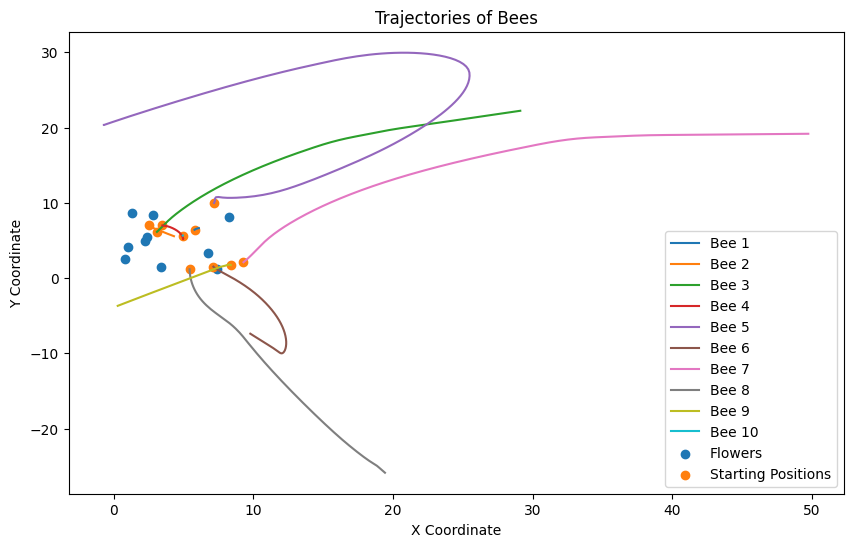

In [541]:
# def ode(t, x, nu, xsi, sigma):
#     # Reshape x to be compatible with flower_positions
#     bee_positions = x.reshape((2, -1))
#     # Calculate the distance from each bee to each flower
#     distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 
#     # Calculate the velocity vector for each bee towards each flower
#     velocity_vector = attraction_to_flower(attraction_differences, distance, sigma)
#     # Sum the influences of all flowers and normalize
#     velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1), axis=0, keepdims=True))
#     return velocity.flatten()

def ode(t, x, nu, xsi, gamma, T_i, decay_factor, eps):
    bee_positions = x.reshape((2, -1))
    distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 

    # Update gamma based on the current time and visitation status
    gamma = gamma_update(gamma, decay_factor=decay_factor, t=t, T_i=T_i)

    velocity_vector = attraction_to_flower(attraction_differences, distance, gamma)
    velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1), axis=0, keepdims=True))
    
    # Check and update visitation status
    for i, d in enumerate(distance.T):  # Loop over flowers
        if np.any(np.linalg.norm(d, axis=0) < eps):  # Check if any bee is close enough to the flower
            T_i[i] = t if T_i[i] == -1 else T_i[i]  # Update the visitation time if not previously visited

    return velocity.flatten()

# # Initialize positions and preferences
# flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
# bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)
# bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
# flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)

# Calculate the differences in attraction
attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]

# # Solve the ODE for the trajectories of the bees
# sol = solve_ivp(ode, [0, 100], bee_positions.flatten(), args=(3, 1, .5), dense_output=True)
# Gamma and Time of Visit Initialization
n = flower_qnty  # Number of flowers
gamma = np.ones(n)  # Initialize gamma as a vector of ones
T_i = -np.ones(n)  # Initialize T_i as a vector of negative ones (indicating no visits yet)
decay_factor = 1.0  # Decay rate for gamma
eps = 0.1  # Epsilon for distance to flower

# Parameters for the ODE
nu = 10
xsi = 1

# Define the time span for the simulation
t_span = [0, 100]  # Start and end times

# Flatten the initial bee positions for solve_ivp
initial_conditions = bee_positions.flatten()

# Call solve_ivp
solution = solve_ivp(ode, t_span, initial_conditions, args=(nu, xsi, gamma, T_i, decay_factor, eps), dense_output=True)

# Extract the solution
trajectory = solution.sol


# Define time points at which to evaluate the solution
time_points = np.linspace(t_span[0], t_span[1], 400)  # Adjust the number of points as needed
trajectories = solution.sol(time_points)

# Plotting
plt.figure(figsize=(10, 6))

num_bees = bee_qnty  # Number of bees
for i in range(num_bees):
    # Extracting the x and y coordinates of the i-th bee
    x = trajectories[i, :]
    y = trajectories[num_bees + i, :]
    plt.plot(x, y, label=f'Bee {i+1}')
# plot the flowers
plt.scatter(flower_positions[0, :], flower_positions[1, :], label='Flowers')
# plot the starting positions of the bees
plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Positions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Trajectories of Bees')
plt.legend()
plt.show()




3002


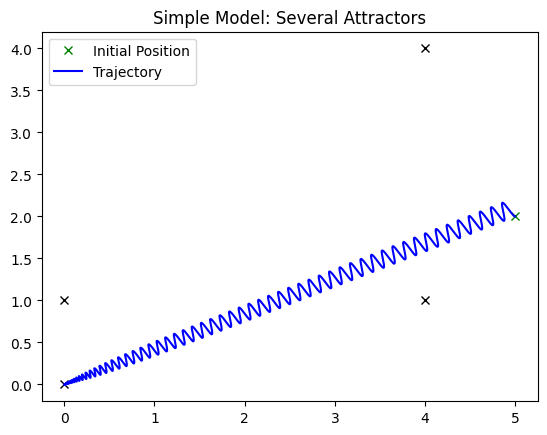

In [135]:
for attractor in attractors:
    plt.plot(attractor[0][0],attractor[0][1],'kx')
plt.plot(5,2,"gx",label="Initial Position")
print(len(sol.y[0]))
plt.plot(sol.y[0],sol.y[1],'b-',label="Trajectory")
plt.title("Simple Model: Several Attractors")
plt.legend(loc="best")
plt.savefig("several_attractors2.png",dpi=100)
